Импорт библиотек

Для работы понадобятся `pandas`, `numpy`, `seaborn`, `matplotlib`, `psycopg2`

In [1]:
import pandas as pd
import psycopg2

import it4fin_functions as it4fin # мои функции выделенные в отдельный модуль

In [2]:
# настройка для pandas для отображения всех строк и колонок
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Создание соединения с базой данных

In [3]:
cnxn = psycopg2.connect(user='postgres',
                        database='postgres',
                        host='localhost',
                        port='5432',
                        password='12345')
print(cnxn.get_dsn_parameters())

# проверочный запрос
pd.read_sql_query("SELECT * FROM stock_orders LIMIT 1", cnxn)

{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


,no,security_code,buysell,order_no,action,price,volume,trade_no,trade_price,order_time
0,36431,RSTI,S,23291,1,0.4562,40000,None,None,10:00:24.718000


## Визуализация бид-аск сперда
> работает долго для больших интервалов с малой частотой

In [4]:
# Параметры
security_code = 'YNDX'
start_time='12:00:00'
end_time='13:00:00'
freq_ms=1000*60*15 # 15 минута

YNDX 12:00:00 13:00:00 900000 ms


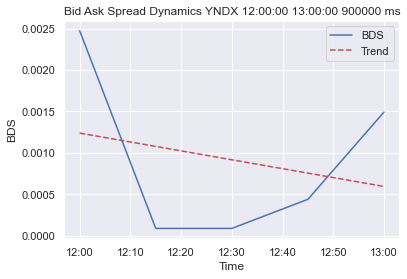

Mean	 = 0.000916384457364079
Median	 = 0.0004396184112190619
Min Max Diff = 0.0023850690985802556
Wall time: 16.5 s


In [5]:
%%time
# с трендом и без сохранения
_ = it4fin.plot_bid_ask_spread_series(cnxn,
                                      security_code=security_code,
                                      start_time=start_time,
                                      end_time=end_time,
                                      freq=freq_ms)

YNDX 12:00:00 13:00:00 900000 ms


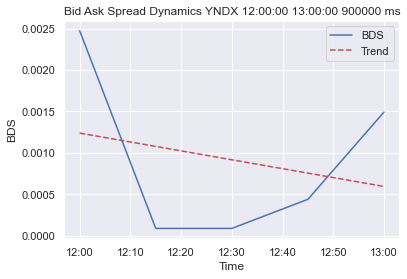

Mean	 = 0.000916384457364079
Median	 = 0.0004396184112190619
Min Max Diff = 0.0023850690985802556

Saved as spread.png
Wall time: 32.1 s


In [6]:
%%time
# с трендом и с сохранением
_ = it4fin.plot_bid_ask_spread_series(cnxn,
                                      security_code=security_code,
                                      start_time=start_time,
                                      end_time=end_time,
                                      freq=freq_ms,
                                      save=True)

Код функции `plot_bid_ask_spread_series(...)` из модуля `it4fin` <br>
*слегка костыльный код*

```python
def plot_bid_ask_spread_series(cnxn, security_code, start_time, end_time, freq, show_trend=True, save=False):
    """
    Построение графика динамики бид аск спреда

    :param cnxn: соединение с базой данных
    :param security_code: тикер для ценной бумаги, например, 'AFLT'
    :param start_time: начало временного интервала, в формате 'HH:MI:SS.mss'
    :param end_time: конец временного интервала в том же формате
    :param freq: частота в миллисекундах
    :param show_trend: (optional) отображать на графике тренд
    :param save:(optional) сохранить как PNG
    """
    bds, _ = get_spread_series(cnxn,
                               security_code=security_code,
                               start_time=start_time,
                               end_time=end_time,
                               freq=freq)

    # некоторые описательные статистики
    diff = abs(bds.max() - bds.min())  # разброс
    mean = bds.mean()  # среднее
    median = bds.median()  # квантиль 0.5 или просто медиана

    if show_trend:
        # линия тренда
        model = np.polyfit([i for i in range(1, len(bds) + 1)], bds.to_list(), 1)
        trend_func = np.poly1d(model)
        trend = trend_func([i for i in range(1, len(bds) + 1)])

    # отрисовка графика
    fig = plt.figure()
    plt.plot(bds.index, bds, label='BDS') # динамика бид аск спреда

    # отрисовка тренда
    if show_trend:
        plt.plot(bds.index, trend, 'r--', label='Trend') # линия тренда

    plt.title(f'Bid Ask Spread Dynamics {security_code} {start_time} {end_time} {freq} ms')

    # подписи осей и легенда
    plt.xlabel('Time')
    plt.ylabel('BDS')
    plt.legend()

    # корректировка корявого вывода оси времени
    if freq < 60*1000:
        fmt = DateFormatter('%H:%M:%S')
    else:
        fmt = DateFormatter('%H:%M')
    # корректировка корявого вывода оси времени
    plt.gcf().axes[0].xaxis.set_major_formatter(fmt)

    # показать график
    plt.show()

    # вывод некоторых описательных статистик
    # (так как график и так перегружен, то нет смысла пихать туда и надписи)
    # вообще говоря это делается через `plt.text()`
    print(f'Mean\t = {mean}')
    print(f'Median\t = {median}')
    print(f'Min Max Diff = {diff}')

    # сохранить график если нужно
    if save:
        directory = input('Directory:')
        filename = input('Name:')

        # проверяем на валидность
        if directory is None or directory == '':
            directory = ''
        elif not directory.endswith('/'):
            directory += '/'

        if not filename.endswith('.png'):
            filename += '.png'

        # сохраняем
        fig.savefig(directory + filename)
        print(f'\nSaved as {directory + filename}')
```

## Визуализация того, как менялась в течение дня по часам оборот

In [7]:
# Аргументы
security_code = ('AFLT',
                 'YNDX')

agg = 'sum'
show_trend = True


('AFLT', 'YNDX')
AFLT
Mean	 = 55383.81436885627
Median	 = 54630.8992443325
Min Max Diff = 39185.09352355072

YNDX
Mean	 = 22556.504464669873
Median	 = 21853.477508650518
Min Max Diff = 18575.455793110898



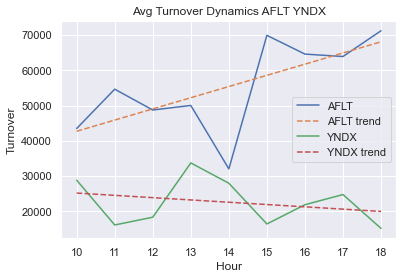

Wall time: 3.49 s


In [8]:
%%time
# с трендом и без сохранения
_ = it4fin.plot_turnover(cnxn,
                         security_code=security_code,
                         agg='avg',
                         show_trend=True,
                         save=False)

('AFLT', 'YNDX')
AFLT
Mean	 = 29410713.555555556
Median	 = 23777224.0
Min Max Diff = 52616246.0

YNDX
Mean	 = 7086806.533333335
Median	 = 5189560.7
Min Max Diff = 23703193.2



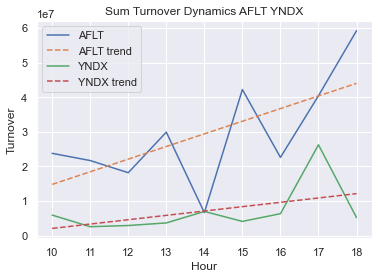


Saved as turnover.png
Wall time: 8.85 s


In [10]:
%%time
# с трендом и с сохранением
_ = it4fin.plot_turnover(cnxn,
                         security_code=security_code,
                         agg='sum',
                         show_trend=True,
                         save=True)

Код функции `plot_turnover(...)` из модуля `it4fin` <br>

```python
def plot_turnover(cnxn, security_code, agg='avg', show_trend=True, save=False):
    """
    :param cnxn: соединение с базой данных
    :param security_code: `tuple` тикеров ценных бумаг, например, ('AFLT', 'YNDX')
    :param agg (default='avg') как аггрегировать (avg = среднее, sum = сумма)
    :param show_trend: (optional) отображать на графике тренд
    :param save:(optional) сохранить как PNG
    """

    with open('template_get_turnover.sql', 'r', encoding='utf-8') as f:
        get_turnover = f.read()

    # печатаем полученные на вход аргументы
    print(security_code)

    query = get_turnover.format(security_code=str(security_code))
    table = pd.read_sql_query(query, cnxn)

    # как аггрегируем
    if agg.lower() == 'avg':
        column = 'avg_turnover'
    elif agg.lower() == 'sum':
        column = 'sum_turnover'

    # ОБОРОТ
    fig1 = plt.figure()
    for sec in security_code:
        filter_table = table[table['security_code'] == sec] # фильтруем по тикеру

        # некоторые описательные статистики
        diff = abs(filter_table[column].max() - filter_table[column].min()) # разброс
        mean = filter_table[column].mean() # среднее
        median = filter_table[column].median() # квантиль 0.5 или просто медиана

        print(sec)
        print(f'Mean\t = {mean}')
        print(f'Median\t = {median}')
        print(f'Min Max Diff = {diff}')
        print()

        if show_trend:  # линия тренда
            model = np.polyfit([i for i in range(1, len(filter_table) + 1)], filter_table[column].to_list(), 1)
            trend_func = np.poly1d(model)
            trend = trend_func([i for i in range(1, len(filter_table) + 1)])

        # график объема
        plt.plot(filter_table['order_hour'], filter_table[column], label=f"{sec}")

        if show_trend:
            plt.plot(filter_table['order_hour'], trend, '--', label=f"{sec} trend")  # линия тренда

    plt.title(f"{agg.capitalize()} Turnover Dynamics {' '.join(security_code)}")

    # подписи осей и легенда
    plt.xlabel('Hour')
    plt.ylabel('Turnover')
    plt.legend()

    # показать график
    plt.show()

    # сохранить график если нужно
    if save:
        directory = input('Directory:')
        filename = input('Name:')

        # проверяем на валидность
        if directory is None or directory == '':
            directory = ''
        elif not directory.endswith('/'):
            directory += '/'

        if not filename.endswith('.png'):
            filename += '.png'

        # сохраняем
        fig1.savefig(directory + filename)
        print(f'\nSaved as {directory + filename}')
```


In [14]:
freq = '100min'

if freq.endswith('ms'):
    freq = int(freq[:-2])
elif freq.endswith('s'):
    freq = 1000 * int(freq[:-1])
elif freq.endswith('min'):
    freq = 1000 * 60 * int(freq[:-3])

freq

6000000